# Lab 5 – Hidden Markov Model for Stock Market Regime Detection

This lab applies a Gaussian Hidden Markov Model (HMM) to stock market price data to identify market regimes 

Importing required library 

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

plt.style.use("seaborn-v0_8")




# Part 1: Data Collection and Preprocessing

1.1) Data Acquisition

In [3]:
# getting data from yahoo finance (yfinance) fo apple 
ticker = "AAPL"
data = yf.download(ticker, start="2014-01-01")
data.head(), data.columns


C:\Users\asus\AppData\Local\Temp\ipykernel_15784\3504846025.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed


(Price           Close       High        Low       Open     Volume
 Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
 Date                                                             
 2014-01-02  17.156698  17.277667  17.122269  17.235793  234684800
 2014-01-03  16.779833  17.174374  16.762772  17.148321  392467600
 2014-01-06  16.871342  16.960361  16.550931  16.670349  412610800
 2014-01-07  16.750679  16.934302  16.684922  16.883434  317209200
 2014-01-08  16.856754  16.921890  16.708801  16.712522  258529600,
 MultiIndex([( 'Close', 'AAPL'),
             (  'High', 'AAPL'),
             (   'Low', 'AAPL'),
             (  'Open', 'AAPL'),
             ('Volume', 'AAPL')],
            names=['Price', 'Ticker']))

In [4]:
#getting columns and size of 
print("coloumn- ",data.columns)
print("size -  ",data.size)

coloumn-  MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
size -   14960


1.2) Preprocessing

In [5]:
close_price = data[('Close', 'AAPL')].copy()
df = close_price.to_frame(name='Close')
df['Return'] = df['Close'].pct_change()
df = df.dropna()

returns = df['Return'].values.reshape(-1, 1)
dates = df.index
df.head()

,Close,Return
Date,,
2014-01-03,16.779833,-0.021966
2014-01-06,16.871342,0.005454
2014-01-07,16.750679,-0.007152
2014-01-08,16.856754,0.006333
2014-01-09,16.641506,-0.012769


# Part 2: Gaussian Hidden Markov Model

2.1 Fitting the Model

In [6]:
from hmmlearn.hmm import GaussianHMM

model = GaussianHMM(n_components=3, covariance_type="full", n_iter=300)
model.fit(returns)
hidden_states = model.predict(returns)
hidden_states

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

2.2 Parameter Analysis

In [7]:
means = model.means_.flatten()
variances = np.array([np.diag(cov)[0] for cov in model.covars_])

for i in range(model.n_components):
    print(f"STATE {i}: Mean = {means[i]:.6f}, Variance = {variances[i]:.6f}")
print("Positive 'Mean' represent bullish trend (upward trend)")
print("Negative 'Mean' represent bearish trend (downwards trend)")

STATE 0: Mean = -0.003252, Variance = 0.003339
STATE 1: Mean = 0.001703, Variance = 0.000119
STATE 2: Mean = 0.000202, Variance = 0.000533
Positive 'Mean' represent bullish trend (upward trend)
Negative 'Mean' represent bearish trend (downwards trend)


# Part 3: Interpretation and Inference

3.1 Inferred Hidden States: decoding the hidden states predicted by the HMM and identifing the time periods corresponding to each hidden state and visualization 


In [8]:
regimes = df.copy()
regimes['State'] = hidden_states
regimes.head()

,Close,Return,State
Date,,,
2014-01-03,16.779833,-0.021966,1
2014-01-06,16.871342,0.005454,1
2014-01-07,16.750679,-0.007152,1
2014-01-08,16.856754,0.006333,1
2014-01-09,16.641506,-0.012769,1


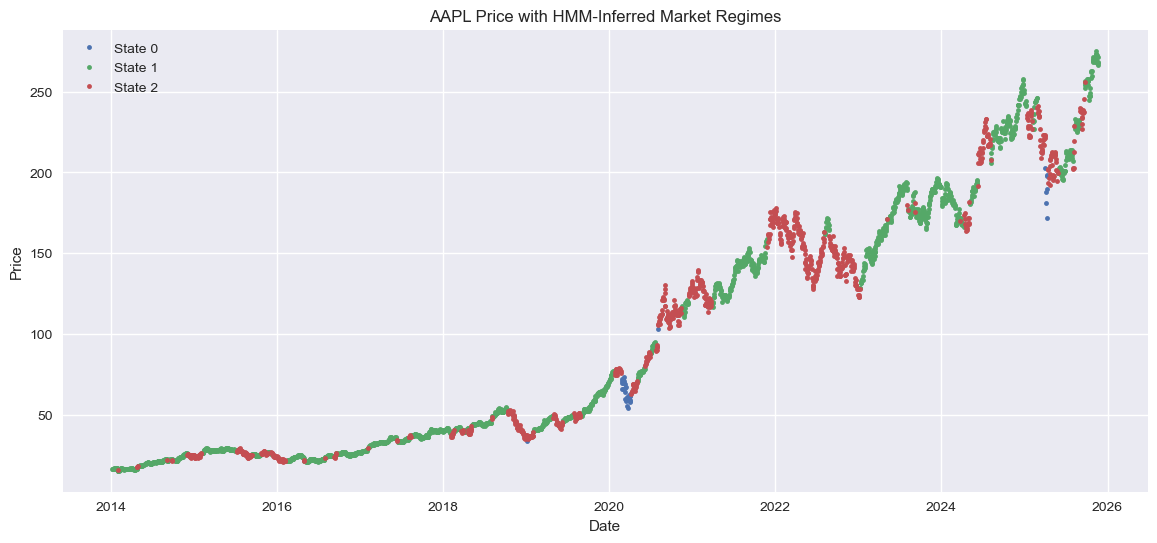

In [9]:
plt.figure(figsize=(14,6))

for s in range(model.n_components):
    subset = regimes[regimes['State'] == s]
    plt.plot(subset.index, subset['Close'], '.', label=f"State {s}")

plt.title("AAPL Price with HMM-Inferred Market Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


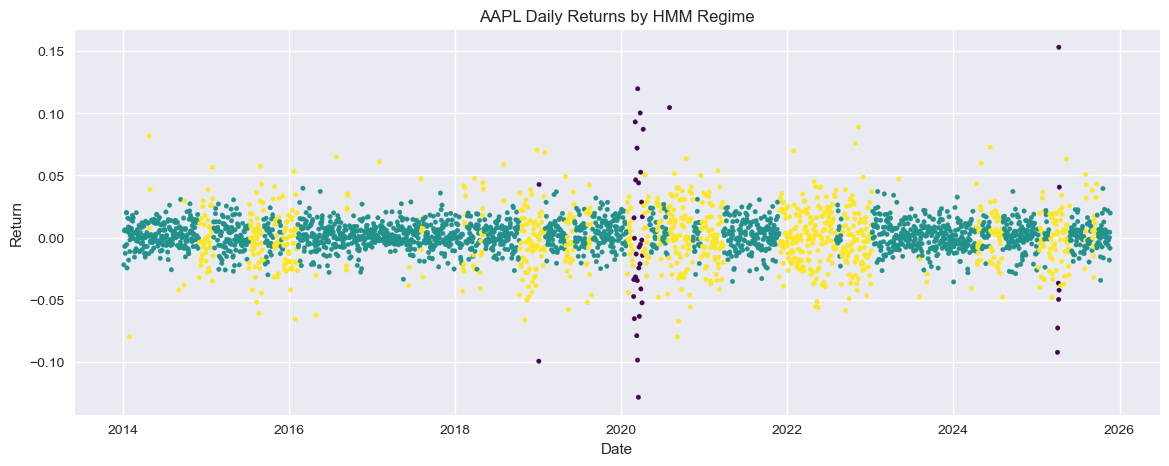

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(regimes.index, regimes['Return'], c=regimes['State'], cmap='viridis', s=10)
plt.title("AAPL Daily Returns by HMM Regime")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()


3.2 Transition Matrix:

In [11]:
print("Transition Matrix:")
print(model.transmat_)

Transition Matrix:
[[8.76895461e-01 4.84296870e-04 1.22620243e-01]
 [7.81903375e-05 9.49250171e-01 5.06716384e-02]
 [7.52569676e-03 9.41983086e-02 8.98275995e-01]]


# Part 4: Evaluation and Visualization


4.1) Visualization

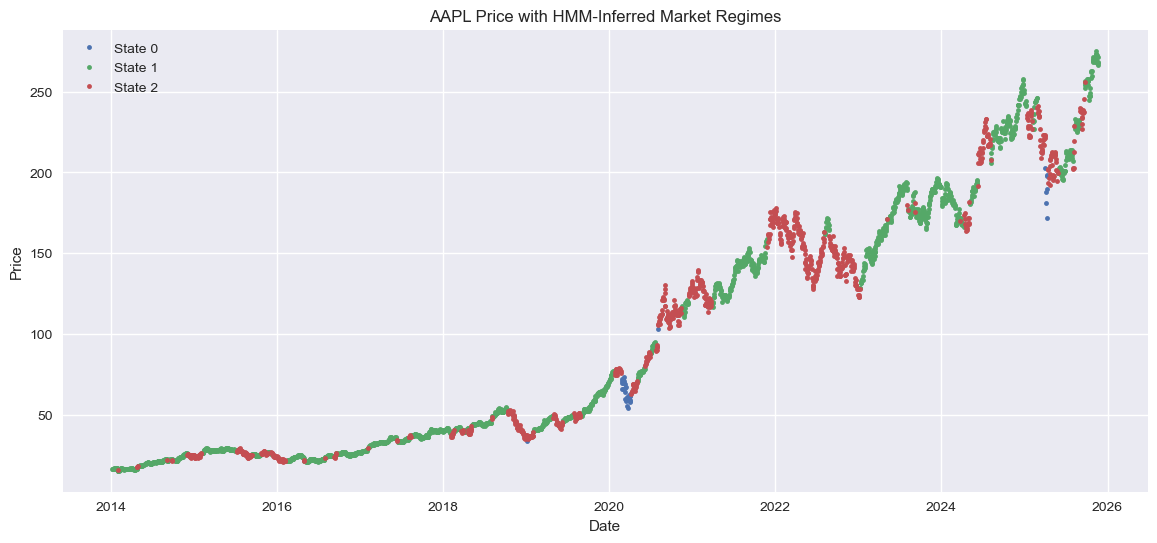

In [12]:
plt.figure(figsize=(14,6))

for s in range(model.n_components):
    subset = regimes[regimes['State'] == s]
    plt.plot(subset.index, subset['Close'], '.', label=f"State {s}")

plt.title("AAPL Price with HMM-Inferred Market Regimes")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


4.2) Model Evaluation

In [13]:
for s in range(model.n_components):
    stay_prob = model.transmat_[s, s]
    duration = 1 / (1 - stay_prob)
    print(f"Expected Duration in State {s}: {duration:.2f} days")


Expected Duration in State 0: 8.12 days
Expected Duration in State 1: 19.70 days
Expected Duration in State 2: 9.83 days


In [14]:
curr = hidden_states[-1]
print("Current State:", curr)
print("Next-day probabilities:", model.transmat_[curr])


Current State: 1
Next-day probabilities: [7.81903375e-05 9.49250171e-01 5.06716384e-02]


In [15]:
dist = np.zeros(model.n_components)
dist[curr] = 1.0

for i in range(10):
    dist = dist @ model.transmat_
    print(f"Day {i+1} distribution: {dist}")


Day 1 distribution: [7.81903375e-05 9.49250171e-01 5.06716384e-02]
Day 2 distribution: [5.24126328e-04 9.05849108e-01 9.36267655e-02]
Day 3 distribution: [0.00123504 0.86869716 0.1300678 ]
Day 4 distribution: [0.00212977 0.83686369 0.16100653]
Day 5 distribution: [0.00314471 0.80956058 0.18729471]
Day 6 distribution: [0.00423041 0.78611988 0.20964971]
Day 7 distribution: [0.00534885 0.76597513 0.22867602]
Day 8 distribution: [0.00647122 0.74864551 0.24488327]
Day 9 distribution: [0.00757604 0.7337226  0.25870136]
Day 10 distribution: [0.00864767 0.7208592  0.27049312]


# Bonus  Part

comparaing regime switching behaviour across different stocks

In [16]:
tickers = ["AAPL", "TSLA", "^GSPC"]
data_dict = {}

for t in tickers:
    df = yf.download(t, start="2014-01-01")
    df["Return"] = df["Close"].pct_change()   # <-- FIXED
    df.dropna(inplace=True)
    data_dict[t] = df

data_dict

C:\Users\asus\AppData\Local\Temp\ipykernel_15784\3890464901.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\asus\AppData\Local\Temp\ipykernel_15784\3890464901.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\asus\AppData\Local\Temp\ipykernel_15784\3890464901.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start="2014-01-01")
[*********************100%***********************]  1 of 1 completed


{'AAPL': Price            Close        High         Low        Open     Volume  \
 Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
 Date                                                                    
 2014-01-03   16.779840   17.174382   16.762780   17.148328  392467600   
 2014-01-06   16.871346   16.960365   16.550935   16.670353  412610800   
 2014-01-07   16.750685   16.934307   16.684928   16.883439  317209200   
 2014-01-08   16.856762   16.921898   16.708809   16.712529  258529600   
 2014-01-09   16.641499   16.962219   16.605208   16.960357  279148800   
 ...                ...         ...         ...         ...        ...   
 2025-11-17  267.459991  270.489990  265.730011  268.820007   45018300   
 2025-11-18  267.440002  270.709991  265.320007  269.989990   45677300   
 2025-11-19  268.559998  272.209991  265.500000  265.529999   40424500   
 2025-11-20  266.250000  275.429993  265.920013  270.829987   45823600   
 2025-11-21  271.489990  273.3

In [17]:
models = {}
hidden_states_dict = {}

for t in tickers:
    returns = data_dict[t]["Return"].values.reshape(-1,1)

    model = GaussianHMM(
        n_components=3,
        covariance_type="diag",
        n_iter=200
    )

    model.fit(returns)
    hidden_states = model.predict(returns)

    models[t] = model
    hidden_states_dict[t] = hidden_states

    print(f"\n===== {t} STATES =====")
    for i in range(model.n_components):
       for i in range(model.n_components):
        mean = float(model.means_[i][0])
        var = float(model.covars_[i].ravel()[0])
        print(f"State {i}: Mean = {mean:.5f}, Var = {var:.5f}")


Model is not converging.  Current: 8157.093774755999 is not greater than 8157.094574986607. Delta is -0.0008002306076377863



===== AAPL STATES =====
State 0: Mean = 0.00204, Var = 0.00013
State 1: Mean = 0.00080, Var = 0.00018
State 2: Mean = -0.00023, Var = 0.00102
State 0: Mean = 0.00204, Var = 0.00013
State 1: Mean = 0.00080, Var = 0.00018
State 2: Mean = -0.00023, Var = 0.00102
State 0: Mean = 0.00204, Var = 0.00013
State 1: Mean = 0.00080, Var = 0.00018
State 2: Mean = -0.00023, Var = 0.00102


Model is not converging.  Current: 9883.813619756089 is not greater than 9883.815806758448. Delta is -0.0021870023592782672



===== TSLA STATES =====
State 0: Mean = 0.00048, Var = 0.00144
State 1: Mean = 0.00145, Var = 0.00047
State 2: Mean = 0.01101, Var = 0.00653
State 0: Mean = 0.00048, Var = 0.00144
State 1: Mean = 0.00145, Var = 0.00047
State 2: Mean = 0.01101, Var = 0.00653
State 0: Mean = 0.00048, Var = 0.00144
State 1: Mean = 0.00145, Var = 0.00047
State 2: Mean = 0.01101, Var = 0.00653

===== ^GSPC STATES =====
State 0: Mean = -0.00154, Var = 0.00020
State 1: Mean = 0.00117, Var = 0.00004
State 2: Mean = -0.00138, Var = 0.00046
State 0: Mean = -0.00154, Var = 0.00020
State 1: Mean = 0.00117, Var = 0.00004
State 2: Mean = -0.00138, Var = 0.00046
State 0: Mean = -0.00154, Var = 0.00020
State 1: Mean = 0.00117, Var = 0.00004
State 2: Mean = -0.00138, Var = 0.00046


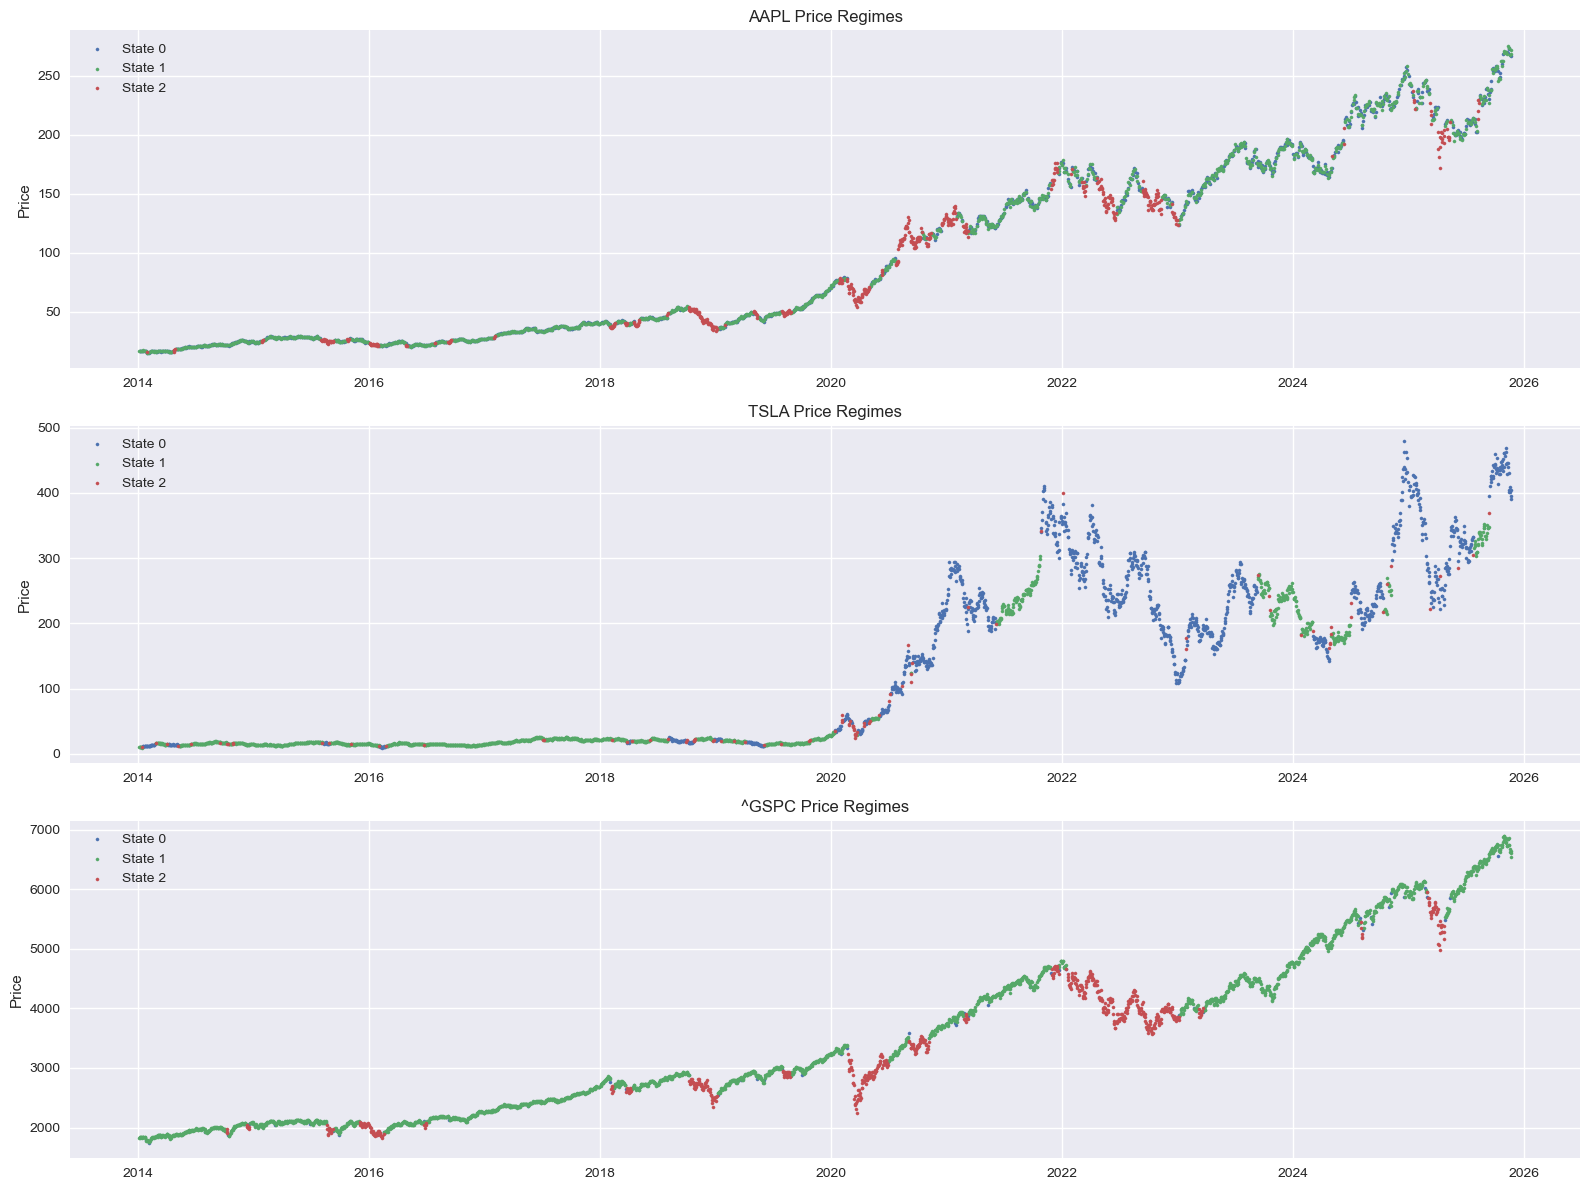

In [18]:
plt.figure(figsize=(16,12))

for i, t in enumerate(tickers):
    df = data_dict[t].copy()
    df["State"] = hidden_states_dict[t]

    plt.subplot(len(tickers),1,i+1)
    for s in range(models[t].n_components):
        idx = df[df["State"] == s].index
        plt.scatter(idx, df.loc[idx, "Close"], s=5, label=f"State {s}")   # <-- FIXED

    plt.title(f"{t} Price Regimes")
    plt.ylabel("Price")
    plt.legend()

plt.tight_layout()
plt.show()


In [19]:
for t in tickers:
    print(f"\n====== TRANSITION MATRIX: {t} ======")
    print(models[t].transmat_)



====== TRANSITION MATRIX: AAPL ======
[[1.03356563e-03 9.51568804e-01 4.73976302e-02]
 [9.81356482e-01 2.20691261e-03 1.64366055e-02]
 [8.32998420e-05 1.27489266e-01 8.72427434e-01]]

====== TRANSITION MATRIX: TSLA ======
[[9.23586896e-01 7.46160066e-04 7.56669438e-02]
 [1.69328292e-04 9.62347024e-01 3.74836474e-02]
 [3.41244137e-01 2.61956012e-01 3.96799851e-01]]

====== TRANSITION MATRIX: ^GSPC ======
[[8.60965548e-02 8.03243165e-01 1.10660280e-01]
 [9.34948730e-02 9.06305095e-01 2.00032198e-04]
 [5.50997708e-02 1.56720291e-07 9.44900073e-01]]


In [20]:
for t in tickers:
    print(f"\n====== EXPECTED DURATIONS FOR {t} ======")
    model = models[t]
    for s in range(model.n_components):
        duration = 1 / (1 - model.transmat_[s][s])
        print(f"State {s}: {duration:.2f} days")



====== EXPECTED DURATIONS FOR AAPL ======
State 0: 1.00 days
State 1: 1.00 days
State 2: 7.84 days

====== EXPECTED DURATIONS FOR TSLA ======
State 0: 13.09 days
State 1: 26.56 days
State 2: 1.66 days

====== EXPECTED DURATIONS FOR ^GSPC ======
State 0: 1.09 days
State 1: 10.67 days
State 2: 18.15 days
